## **Causal transformer model using pre-trained word embeddings to identify topic.**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow

## **Import Libraries**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Attention, LayerNormalization, Dropout
from tensorflow.keras.layers import Input,Dense,Dropout, Flatten,Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,RMSprop,Adagrad
from tensorflow.keras import initializers
from tensorflow.keras.initializers import Constant
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
import os
from tensorflow.keras import layers
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
#from sklearn.metrices import classification report
from gensim.models.keyedvectors import KeyedVectors
import warnings
warnings.filterwarnings(action='ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


## **Read Dataset and Check For Null Values**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
topic=pd.read_excel("/content/topics_updated.xlsx")

In [5]:
topic.head(5)

,title,content,keywords,entities,keywords_ex,topic,content_file
0,Bicep Curl Drop Set: Pump Your Guns and Maximi...,fcda08714583ddf76ea02784122767b0538730be9a2376...,"['biceps', 'muscle', 'leg', 'days', 'youll', '...","['Drop', 'Muscleripping', 'Research', 'Plan', ...","['drop set', 'drop sets', 'sets', 'Drop set', ...",unknown,The biceps are arguably the most loved muscle ...
1,Wabash Theater Closes Season with Hand to God,f76bad70f9f327139e4a0014e599971169ae806b5f27e9...,"['caps', 'mainstage', 'comedies', 'fivetime', ...","['Robert Askins', 'Jason', 'Jim Cherry', 'Marg...","['puppet', 'wabash theater', 'play', 'Jason', ...",entertainment,The Wabash Theater Department caps a year of m...
2,Pandemic restrictions at county-run LTC homes ...,fa111b60bf919c60e30547dee062a93830a15486bc2ce6...,"['Restrictions', 'care', 'homes', 'years', 'th...","['Barrie', 'Lisa Garratt', 'Garratt', 'LTC', '...","['staff', 'residents', 'visitors', 'Lisa Garra...",health,Restrictions put in place at long-term care ho...
3,CAUGHT ON CAMERA: Loose pickup truck wheel sma...,f73e1f77ecfce573f935abf4d2a0802219fe979b6eb85b...,"['pickup', 'truck', 'wheel', 'cars', 'windshie...","['Loose', 'Monday April', 'HSD', 'OPP', 'Try',...","['pickup truck', 'windshield', 'highway', 'tru...",technology,Loose pickup truck wheel smashes into car’s wi...
4,Brochure scanning: Toyota Vista,f6d3c7c0c346dda25a367d77293914befc48d6e6f08b95...,"['inital', 'post', 'feed', 'scans', 'beauty', ...","['JDM Classic', 'JDM', 'Food']","['JDM', 'JDM Classic']",entertainment,Following on from my inital post earlier this ...


<Axes: xlabel='topic', ylabel='count'>

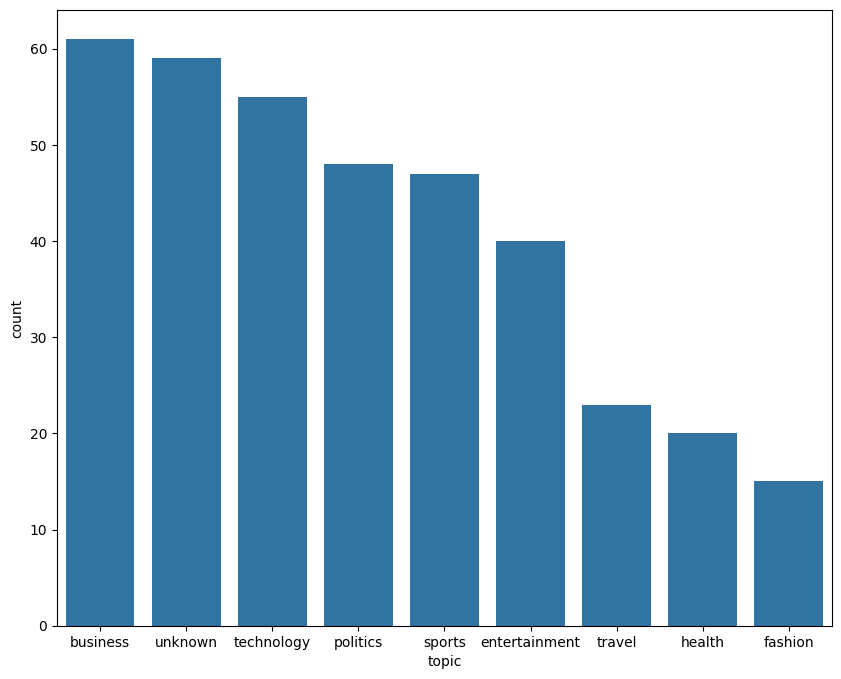

In [6]:
topic['topic'].value_counts()
plt.figure(figsize=(10,8))
sns.barplot(x=topic['topic'].value_counts().index,y=topic['topic'].value_counts())

In [7]:
topic.isnull().sum()

title           0
content         0
keywords        0
entities        0
keywords_ex     0
topic           0
content_file    0
dtype: int64

In [ ]:
#topic['title'].fillna('Unknown',inplace=True)
#topic['entities'].fillna('Unknown',inplace=True)
#topic['keywords_ex'].fillna('Unknown',inplace=True)
#topic['keywords'].fillna('Unknown',inplace=True)
#topic['topic'].fillna('Unknown',inplace=True)
#topic['content'].fillna('Unknown',inplace=True)

In [ ]:
# drop unimportant columns
#topic_copy=topic.copy()
#topic_copy=topic_copy.drop(columns=['content_word_count', 'published_date','created_at', 'updated_at', 'language', 'article_links','total_share_count', 'keywords_status', 'sentiment', 'title_sentiment','infographic','case_study', 'review', 'video', 'podcast', 'webinar', 'interview','quote', 'meme', 'give_away', 'quiz', 'cities_and_states', 'countries','geo_locations'])

## **Extract Content From Text Files Into Excel File**

In [ ]:
# read .txt file
def read_text_file(file_path):
  with open(file_path,'r') as file:
    content=file.read()
  return content

In [ ]:
topic_copy['content_file']=''
topic_copy.head(2)

,title,content,keywords,entities,keywords_ex,topic,content_file
0,Mitsubishi Motors Co. (OTCMKTS:MMTOF) Short In...,29c9689e5ed81852967ff964f16be109a37dd9ecb1f5c9...,"['recipient', 'growth', 'interest', 'shares', ...","['Mitsubishi Motors Co', 'Citigroup', 'Mitsubi...","['mitsubishi motors', 'shares', 'vehicles', 'M...",business,
1,Juventus off the hook! Bianconeri set to have ...,b9e3313535ffdbc2fe198572f17ce61330980dfab64324...,"['developments', 'reversal', 'deduction', 'tes...","['Ugo Taucer', 'Taucers', 'Juventus', 'Collegi...","['bianconeri set', 'serie', 'hook', 'deduction...",sports,


In [ ]:
for index, row in topic_copy.iterrows():
  if not isinstance(row['content'], str):
    print(f"Row {index}: {row['content']} is not a string")

Row 10000: nan is not a string


In [ ]:
# iterate in dataset
for index, row in topic_copy.iterrows():
  file_name=row['content']
  file_path=os.path.join('/content/drive/MyDrive/text_subset',str(file_name))
  if os.path.exists(file_path):
    content=read_text_file(file_path)
    topic_copy.at[index,'content_file']=content

topic_copy.to_excel('topics_updated.xlsx',index=False)

## **Text Data Preprocessing**

In [8]:
topic_copy=topic.copy()

In [9]:
import re
def preprocess(text):
  if isinstance(text,str):
    text=re.sub(r'@\w+', '', text) #remove username
    text=re.sub(r'\S+@\S+', '', text) #remove email id
    text=re.sub(r'#\w+', '', text) #remove hashtag
    text=re.sub(r'https?://\S+', '', text) #remove links
    text=re.sub(r'[^a-zA-Z0-9\s$!]+', '', text) #remove special characters
    text=text.lower() # covert to lower case
    return text
  else:
    return text
topic_copy['cleaned_content_file']=topic_copy['content_file'].apply(preprocess)
topic_copy.head(2)

,title,content,keywords,entities,keywords_ex,topic,content_file,cleaned_content_file
0,Bicep Curl Drop Set: Pump Your Guns and Maximi...,fcda08714583ddf76ea02784122767b0538730be9a2376...,"['biceps', 'muscle', 'leg', 'days', 'youll', '...","['Drop', 'Muscleripping', 'Research', 'Plan', ...","['drop set', 'drop sets', 'sets', 'Drop set', ...",unknown,The biceps are arguably the most loved muscle ...,the biceps are arguably the most loved muscle ...
1,Wabash Theater Closes Season with Hand to God,f76bad70f9f327139e4a0014e599971169ae806b5f27e9...,"['caps', 'mainstage', 'comedies', 'fivetime', ...","['Robert Askins', 'Jason', 'Jim Cherry', 'Marg...","['puppet', 'wabash theater', 'play', 'Jason', ...",entertainment,The Wabash Theater Department caps a year of m...,the wabash theater department caps a year of m...


In [10]:
# remove emoji
def emoji_removal(text1):
  if isinstance(text1,str):
    emoji_pattern=re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F700-\U0001F77F"
        u"\U0001F780-\U0001F7FF"
        u"\U0001F800-\U0001F8FF"
        u"\U0001F900-\U0001F9FF"
        u"\U0001FA00-\U0001FA6F"
        u"\U0001FA70-\U0001FAFF"
        u"\U00012702-\U000127B0"
        u"\U000124C2-\U0001F251"
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'',text1)
  else:
    return text1
topic_copy['cleaned_content_file']=topic_copy['cleaned_content_file'].apply(emoji_removal)
topic_copy['cleaned_content_file'].iloc[1]

'the wabash theater department caps a year of mainstage comedies when the fivetime tonynominated play hand to god opens wednesday for a fournight run in ball theater curtain is at 8 pm and free tickets can be reserved through the box office\n\nhand of god is an irreverent raunchy comedy that was nominated for a tony award for best new play in 2015 after an extensive offbroadway run written by playwright robert askins the play tells the story of a quiet awkward teenager jason who after his father dies struggles with all the difficulties of adolescence the cruelty of bullies the discovery of love the shifting relationships with parents and the inevitable questioning of what it all means\n\nquoting writer john patrick shanley hand to god director jim cherry says theater is the safe place to do unsafe things adding this play is utterly outrageous and overthetop even gleeful in its willingness to break taboos its a lot like south park in that way but at the same time it deals with sensitive

In [11]:
# negation handling
topic_copy['cleaned_content_file']=topic_copy['cleaned_content_file'].apply(lambda x: re.sub(r'\b(?:not|no|never)\s+(\w+)',r'not_\1',str(x)))
topic_copy['cleaned_content_file'].iloc[1]

'the wabash theater department caps a year of mainstage comedies when the fivetime tonynominated play hand to god opens wednesday for a fournight run in ball theater curtain is at 8 pm and free tickets can be reserved through the box office\n\nhand of god is an irreverent raunchy comedy that was nominated for a tony award for best new play in 2015 after an extensive offbroadway run written by playwright robert askins the play tells the story of a quiet awkward teenager jason who after his father dies struggles with all the difficulties of adolescence the cruelty of bullies the discovery of love the shifting relationships with parents and the inevitable questioning of what it all means\n\nquoting writer john patrick shanley hand to god director jim cherry says theater is the safe place to do unsafe things adding this play is utterly outrageous and overthetop even gleeful in its willingness to break taboos its a lot like south park in that way but at the same time it deals with sensitive

In [12]:
# slang handling
slang_dict={
    'noo':'no',
    'bf':'boy friend',
    'errr':'error',
    'PRW': 'Parents Are Watching',
    'QPSA': 'Que Pasa?',
    'ROFL': 'Rolling On The Floor Laughing',
    'ROFLOL': 'Rolling On The Floor Laughing Out Loud',
    'ROTFLMAO': 'Rolling On The Floor Laughing My A.. Off',
    'SK8': 'Skate',
    'STATS': 'Your sex and age',
    'ASL': 'Age, Sex, Location',
    'THX': 'Thank You',
    'TTFN': 'Ta-Ta For Now!',
    'TTYL': 'Talk To You Later',
    'U': 'You',
    'U2': 'You Too',
    'U4E': 'Yours For Ever',
    'WB': 'Welcome Back',
    'WTF': 'What The F...',
    'FREQ':'Frequency',
    'gf':'girl friend',
    'jr': 'junior',
    'AFAIK':'As Far As I Know',
    'ICQ': 'I Seek you (also a chat program)',
    'ILU': 'ILU: I Love You',
    'IMHO': 'In My Honest/Humble Opinion',
    'IMO': 'In My Opinion',
    'IOW': 'In Other Words',
    'IRL': 'In Real Life',
    'KISS': 'Keep It Simple, Stupid',
    'LDR': 'Long Distance Relationship',
    'LMAO': 'Laugh My A.. Off',
    'LOL': 'Laughing Out Loud',
    'LTNS': 'Long Time No See',
    'L8R': 'Later',
    'MTE': 'My Thoughts Exactly',
    'M8': 'Mate',
    'NRN': 'No Reply Necessary',
    'OIC': 'Oh I See',
    'PITA': 'Pain In The A..',
    'PRT': 'Party',
    'WTG': 'Way To Go!',
    'WUF': 'Where Are You From?',
    'W8': 'Wait...',
    '7K': 'Sick:-D Laugher',
    'TFW': 'That feeling when. TFW internet slang often goes in a caption to an image.',
    'MFW': 'My face when',
    'MRW': 'My reaction when',
    'IFYP': 'I feel your pain',
    'TNTL': 'Trying not to laugh',
    'JK': 'Just kidding',
    'IDC': 'I don’t care',
    'ILY': 'I love you',
    'IMU': 'I miss you',
    'ADIH': 'Another day in hell',
    'ZZZ': 'Sleeping, bored, tired',
    'WYWH': 'Wish you were here',
    'TIME': 'Tears in my eyes',
    'BAE': 'Before anyone else',
    'FIMH': 'Forever in my heart',
    'BSAAW': 'Big smile and a wink',
    'BWL': 'Bursting with laughter',
    'LMAO': 'Laughing my a** off',
    'BFF': 'Best friends forever',
    'CSL': 'Can’t stop laughing',
    'CU': 'see you',
    'ATM':'At The Moment',
    'A3':'Anytime, Anywhere, Anyplace',
    'BAK':'Back At Keyboard',
    'BRT': 'Be Right There',
    'BTW': 'By The Way',
    'B4': 'Before',
    'B4N': 'Bye For Now',
    'CU': 'See You',
    'CUL8R': 'See You Later',
    "AFK":'Away From Keyboard',
    'ASAP':'As Soon As Possible',
    'ATK':'At The Keyboard',
    'CYA': 'See You',
    'FAQ': 'Frequently Asked Questions',
    'FC': 'Fingers Crossed',
    'FWIW': 'For What It\'s Worth',
    'FYI': 'For Your Information',
    'GAL': 'Get A Life',
    'GG': 'Good Game',
    'GN': 'Good Night',
    'GMTA': 'Great Minds Think Alike',
    'GR8': 'Great!',
    'G9': 'Genius',
    'IC': 'I See',
    'BBL':'Be Back Later',
    'BBS': 'Be Back Soon',
    'BFN': 'Bye For Now',
    'B4N': 'Bye For Now',
    'BRB': 'Be Right Back'
}
topic_copy['cleaned_content_file']=topic_copy['cleaned_content_file'].apply(lambda x: ' '.join(slang_dict.get(word, word) for word in x.split()))
topic_copy['cleaned_content_file'].iloc[1]

'the wabash theater department caps a year of mainstage comedies when the fivetime tonynominated play hand to god opens wednesday for a fournight run in ball theater curtain is at 8 pm and free tickets can be reserved through the box office hand of god is an irreverent raunchy comedy that was nominated for a tony award for best new play in 2015 after an extensive offbroadway run written by playwright robert askins the play tells the story of a quiet awkward teenager jason who after his father dies struggles with all the difficulties of adolescence the cruelty of bullies the discovery of love the shifting relationships with parents and the inevitable questioning of what it all means quoting writer john patrick shanley hand to god director jim cherry says theater is the safe place to do unsafe things adding this play is utterly outrageous and overthetop even gleeful in its willingness to break taboos its a lot like south park in that way but at the same time it deals with sensitive issue

In [13]:
# idioms and abbreviations handling
idioms_dict={'omg':'oh my god','rofl':'rolling on the floor laughing'}
topic_copy['cleaned_content_file']=topic_copy['cleaned_content_file'].apply(lambda x: ' '.join(idioms_dict.get(word,word) for word in x.split()))
topic_copy['cleaned_content_file'].iloc[1]

'the wabash theater department caps a year of mainstage comedies when the fivetime tonynominated play hand to god opens wednesday for a fournight run in ball theater curtain is at 8 pm and free tickets can be reserved through the box office hand of god is an irreverent raunchy comedy that was nominated for a tony award for best new play in 2015 after an extensive offbroadway run written by playwright robert askins the play tells the story of a quiet awkward teenager jason who after his father dies struggles with all the difficulties of adolescence the cruelty of bullies the discovery of love the shifting relationships with parents and the inevitable questioning of what it all means quoting writer john patrick shanley hand to god director jim cherry says theater is the safe place to do unsafe things adding this play is utterly outrageous and overthetop even gleeful in its willingness to break taboos its a lot like south park in that way but at the same time it deals with sensitive issue

In [14]:
# remove stop words
stop_word=set(stopwords.words('english'))
topic_copy['cleaned_content_file']=topic_copy['cleaned_content_file'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_word]))
topic_copy['cleaned_content_file'].iloc[1]

'wabash theater department caps year mainstage comedies fivetime tonynominated play hand god opens wednesday fournight run ball theater curtain 8 pm free tickets reserved box office hand god irreverent raunchy comedy nominated tony award best new play 2015 extensive offbroadway run written playwright robert askins play tells story quiet awkward teenager jason father dies struggles difficulties adolescence cruelty bullies discovery love shifting relationships parents inevitable questioning means quoting writer john patrick shanley hand god director jim cherry says theater safe place unsafe things adding play utterly outrageous overthetop even gleeful willingness break taboos lot like south park way time deals sensitive issues gets interesting ideas jason attends church cypress texas mom margery leads christian puppet ministry attempts instill biblical values teenage participants nothing close actual desires felt young people things go dark dark jasons puppet tyrone takes life foul mouth

In [15]:
# tokenize sentence
tokenizer=Tokenizer()
tokenizer.fit_on_texts(topic_copy['cleaned_content_file'])
X=tokenizer.texts_to_sequences(topic_copy['cleaned_content_file'])
#topic_copy['Tokens']=topic_copy['cleaned_content_file'].apply(lambda x: word_tokenize(str(x)))
#topic_copy.head(2)

In [16]:
# add padding
X=pad_sequences(X)

## **Split Data and One Hot Encoding**

In [ ]:
#label encoding
#from sklearn.preprocessing import LabelEncoder
#label_encoder=LabelEncoder()
#y=label_encoder.fit_transform(topic_copy['topic'])

In [ ]:
#y=y.tolist()

In [17]:
y=topic_copy['topic']
y=pd.get_dummies(y) # one-hot encoding

In [18]:
#split into train test result
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

## **Load Glove Embeddings**

In [19]:
embedding_index={}
with open('/content/drive/MyDrive/glove.6B/glove.6B.100d.txt',encoding='utf-8') as f:
  for line in f:
    word, coefs=line.split(maxsplit=1)
    coefs=np.fromstring(coefs,'f',sep=' ')
    embedding_index[word]=coefs

In [20]:
max_num_words=30000
embedding_dim=50
max_sequence_length=3125

In [21]:
# prepare embedding matrix
word_index=tokenizer.word_index
num_words=min(len(word_index)+1,max_num_words)
embedding_matrix=np.zeros((num_words,embedding_dim))

for word, i in word_index.items():
  if i>=max_num_words:
    continue
  embedding_vector=embedding_index.get(word)
  if embedding_vector is not None:
    embedding_vector=np.resize(embedding_vector,(embedding_dim,))
    embedding_matrix[i]=embedding_vector

In [22]:
# define embedding layer
embedding_layer=Embedding(num_words,embedding_dim,embeddings_initializer=Constant(embedding_matrix),input_length=max_sequence_length,trainable=False)
sequence_input=Input(shape=(max_sequence_length,),dtype='int32')
embedded_sequence=embedding_layer(sequence_input)

## **Build Transformer Model and Train**

In [23]:
num_heads=2
transformer_unit=64
dropout_rate=0.2

In [24]:
# transformer layer
attention_output=embedded_sequence
for _ in range(num_heads):
  attention_output=Attention(use_scale=True)([attention_output,attention_output])
attention_output=LayerNormalization()(attention_output)
attention_output=Dropout(dropout_rate)(attention_output)

In [25]:
# dense layer
transformer_output=Flatten()(attention_output)
transformer_output=Dense(transformer_unit,activation='relu')(transformer_output)
transformer_output=Dropout(dropout_rate)(transformer_output)

In [26]:
# output layer
output=Dense(9,activation='softmax')(transformer_output)

In [27]:
# compile model
model=Model(sequence_input,output)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 3125)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 3125, 50)             1029400   ['input_1[0][0]']             
                                                                                                  
 attention (Attention)       (None, 3125, 50)             1         ['embedding[0][0]',           
                                                                     'embedding[0][0]']           
                                                                                                  
 attention_1 (Attention)     (None, 3125, 50)             1         ['attention[0][0]',       

In [31]:
# train model
model.fit(X_train,y_train,batch_size=32,epochs=12,validation_data=(X_test,y_test))

Epoch 1/12
10/10 [==============================] - 3s 327ms/step - loss: 1.6478 - accuracy: 0.4218 - val_loss: 2.8341 - val_accuracy: 0.2973
Epoch 2/12
10/10 [==============================] - 3s 325ms/step - loss: 1.4796 - accuracy: 0.4898 - val_loss: 3.3048 - val_accuracy: 0.4054
Epoch 3/12
10/10 [==============================] - 3s 327ms/step - loss: 1.4686 - accuracy: 0.4966 - val_loss: 2.8806 - val_accuracy: 0.3378
Epoch 4/12
10/10 [==============================] - 3s 322ms/step - loss: 1.5337 - accuracy: 0.4422 - val_loss: 3.1210 - val_accuracy: 0.3784
Epoch 5/12
10/10 [==============================] - 3s 326ms/step - loss: 1.7345 - accuracy: 0.4082 - val_loss: 2.4307 - val_accuracy: 0.2838
Epoch 6/12
10/10 [==============================] - 3s 323ms/step - loss: 1.5678 - accuracy: 0.4218 - val_loss: 2.2661 - val_accuracy: 0.3108
Epoch 7/12
10/10 [==============================] - 3s 325ms/step - loss: 1.5022 - accuracy: 0.4796 - val_loss: 2.5344 - val_accuracy: 0.3243
Epoch 

In [33]:
# save model
model.save("/content/drive/MyDrive/model.h5")

## **Show Below Metrics**


*   CONFUSION MATRIX
*   CLASSIFICATION REPORT
*   AUC SCORE
*   ROC Curve

In [37]:
#print confusion matrix and classification report
from sklearn.metrics import confusion_matrix,classification_report
predict_label=tf.argmax(predictions,axis=1)
y_test_int=np.argmax(y_test,axis=1)
predict_label_np=predict_label.numpy()
print("Confusion Matrix:")
print(confusion_matrix(y_test_int,predict_label_np))
print("  ")
print("Classification Report:")
print(classification_report(y_test_int,predict_label_np))

Confusion Matrix:
[[6 4 0 0 1 0 0 0 0]
 [0 3 0 0 1 0 2 0 1]
 [1 4 0 0 0 0 1 0 2]
 [1 1 0 0 3 0 0 0 0]
 [0 1 1 0 6 0 0 0 0]
 [0 1 0 0 0 9 0 0 0]
 [0 4 0 0 1 0 5 0 0]
 [0 4 0 0 1 0 0 0 0]
 [1 6 0 0 2 0 1 0 0]]
  
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.55      0.60        11
           1       0.11      0.43      0.17         7
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00         5
           4       0.40      0.75      0.52         8
           5       1.00      0.90      0.95        10
           6       0.56      0.50      0.53        10
           7       0.00      0.00      0.00         5
           8       0.00      0.00      0.00        10

    accuracy                           0.39        74
   macro avg       0.30      0.35      0.31        74
weighted avg       0.36      0.39      0.36        74



AUC_Score: 0.7480653797861916


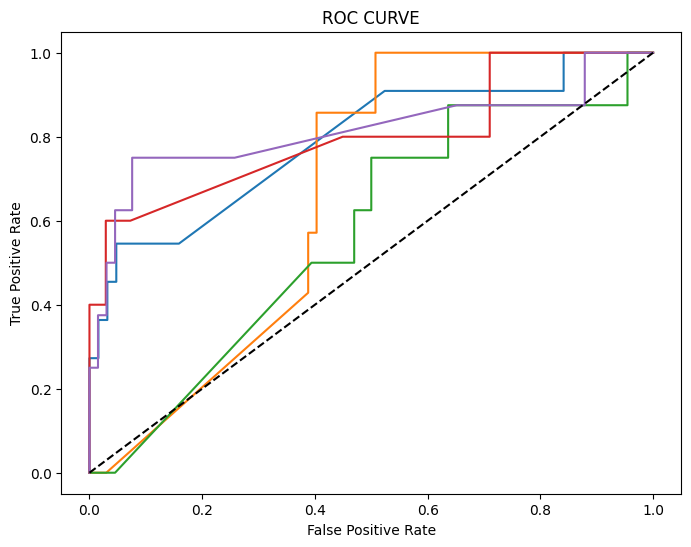

In [38]:
# calculate AUC score and Plot ROC curve
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.preprocessing import label_binarize

auc_score=roc_auc_score(y_test,predictions,multi_class='ovr')
print("AUC_Score:", auc_score)

plt.figure(figsize=(8,6))
for i in range(5):
  y_test_bin=label_binarize(y_test,classes=[0,1,2,3,4,5,6,7,8])
  fpr,tpr,thresolds=roc_curve(y_test_bin[:, i],predictions[:, i])
  plt.plot(fpr,tpr,label=f"Class {i}")

plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.show()

## **Evaluate Model and Predict**

In [35]:
loss, accuracy=model.evaluate(X_test,y_test)
print("Val Accuracy:", accuracy)

3/3 [==============================] - 0s 93ms/step - loss: 3.2350 - accuracy: 0.3919
Val Accuracy: 0.3918918967247009


In [36]:
predictions=model.predict(X_test)

3/3 [==============================] - 1s 90ms/step


In [48]:
def topic_mapping(predictions):
    """
    Map model predictions to topic labels.

    Args:
    - predictions: Predicted probabilities for each topic.

    Returns:
    - topic_labels: Predicted topic labels.
    """
    topic_labels = []
    # Assuming each prediction is a probability distribution over topics
    for prediction in predictions:
        # Get the index of the topic with the highest probability
        predicted_topic_index = prediction.argmax()
        # Map the index to the corresponding topic label
        topics = ['business', 'unknown', 'technology', 'politics', 'sports topic', 'entertainment', 'travel', 'health', 'fashion']
        predicted_topic_label = topics[predicted_topic_index]
        topic_labels.append(predicted_topic_label)
    return topic_labels

In [49]:
# Convert predictions to topic labels
predicted_topics = [topic_mapping(prediction) for prediction in predictions]

In [56]:
# Update the DataFrame with predicted topics
#topic_copy['predicted_topic'] = predicted_topics

## **Model Tuning**

In [ ]:
# compile model
from keras.optimizers import Adam
model1=Model(sequence_input,output)
learning_rate=1e-4
model1.compile(loss='categorical_crossentropy',optimizer='RMSProp',metrics=['accuracy'])

In [ ]:
# train model
model1.fit(X_train,y_train,batch_size=32,epochs=5,validation_data=(X_test,y_test))

Epoch 1/5
10/10 [==============================] - 5s 370ms/step - loss: 1.2354 - accuracy: 0.5374 - val_loss: 3.9208 - val_accuracy: 0.4730
Epoch 2/5
10/10 [==============================] - 3s 337ms/step - loss: 1.3571 - accuracy: 0.5136 - val_loss: 2.9275 - val_accuracy: 0.4054
Epoch 3/5
10/10 [==============================] - 3s 336ms/step - loss: 1.2641 - accuracy: 0.4932 - val_loss: 4.3646 - val_accuracy: 0.4865
Epoch 4/5
10/10 [==============================] - 3s 340ms/step - loss: 1.2501 - accuracy: 0.5136 - val_loss: 4.1746 - val_accuracy: 0.4730
Epoch 5/5
10/10 [==============================] - 3s 343ms/step - loss: 1.2524 - accuracy: 0.4898 - val_loss: 3.9843 - val_accuracy: 0.4595


In [ ]:
# save model
model1.save("/content/drive/MyDrive/model1.h5")

In [ ]:
loss, accuracy=model1.evaluate(X_test,y_test)
print("Val Accuracy:", accuracy)

3/3 [==============================] - 0s 97ms/step - loss: 3.7388 - accuracy: 0.5000
Val Accuracy: 0.5


In [ ]:
predictions_model1=model1.predict(X_test)

3/3 [==============================] - 0s 85ms/step


AUC_Score: 0.7881378059517593


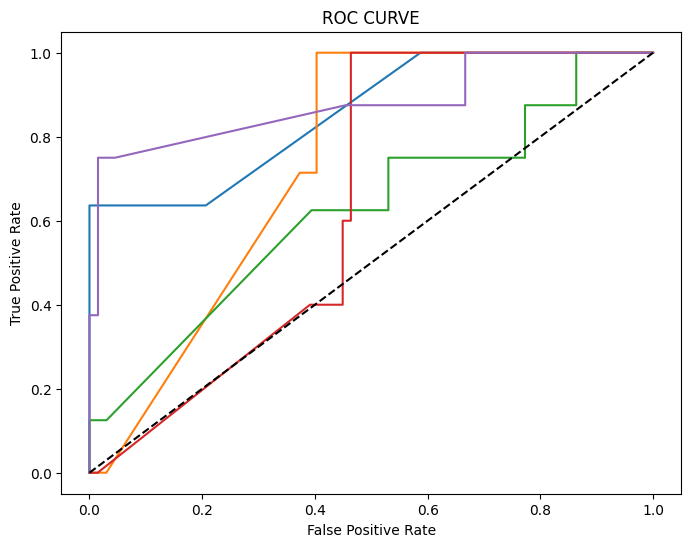

In [ ]:
# calculate AUC score and Plot ROC curve
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.preprocessing import label_binarize

auc_score_tuning=roc_auc_score(y_test,predictions_model1,multi_class='ovr')
print("AUC_Score:", auc_score_tuning)

plt.figure(figsize=(8,6))
for i in range(5):
  y_test_bin=label_binarize(y_test,classes=[0,1,2,3,4,5,6,7,8])
  fpr,tpr,thresolds=roc_curve(y_test_bin[:, i],predictions_model1[:, i])
  plt.plot(fpr,tpr,label=f"Class {i}")

plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.show()

In [ ]:
# compile model
from keras.optimizers import Adam
model2=Model(sequence_input,output)
learning_rate=1e-4
model2.compile(loss='categorical_crossentropy',optimizer='Adagrad',metrics=['accuracy'])

In [ ]:
# train model
model2.fit(X_train,y_train,batch_size=32,epochs=20,validation_data=(X_test,y_test))

Epoch 1/20
10/10 [==============================] - 3s 340ms/step - loss: 1.1980 - accuracy: 0.5544 - val_loss: 3.6060 - val_accuracy: 0.4595
Epoch 2/20
10/10 [==============================] - 3s 330ms/step - loss: 1.2097 - accuracy: 0.5476 - val_loss: 3.6054 - val_accuracy: 0.4730
Epoch 3/20
10/10 [==============================] - 3s 332ms/step - loss: 1.2791 - accuracy: 0.5272 - val_loss: 3.5977 - val_accuracy: 0.4865
Epoch 4/20
10/10 [==============================] - 3s 328ms/step - loss: 1.2296 - accuracy: 0.5408 - val_loss: 3.6048 - val_accuracy: 0.4865
Epoch 5/20
10/10 [==============================] - 3s 334ms/step - loss: 1.1473 - accuracy: 0.5646 - val_loss: 3.6201 - val_accuracy: 0.4865
Epoch 6/20
10/10 [==============================] - 3s 336ms/step - loss: 1.3051 - accuracy: 0.5408 - val_loss: 3.6111 - val_accuracy: 0.4865
Epoch 7/20
10/10 [==============================] - 3s 334ms/step - loss: 1.2446 - accuracy: 0.5238 - val_loss: 3.6216 - val_accuracy: 0.4865
Epoch 

In [ ]:
# save model
model2.save("/content/drive/MyDrive/model2.h5")

In [ ]:
loss, accuracy=model2.evaluate(X_test,y_test)
print("Val Accuracy:", accuracy)

3/3 [==============================] - 0s 89ms/step - loss: 3.7388 - accuracy: 0.5000
Val Accuracy: 0.5


In [ ]:
predictions_model2=model2.predict(X_test)

3/3 [==============================] - 0s 91ms/step


In [ ]:
# calculate AUC score and Plot ROC curve
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.preprocessing import label_binarize

auc_score_tuning1=roc_auc_score(y_test,predictions_model2,multi_class='ovr')
print("AUC_Score:", auc_score_tuning1)

AUC_Score: 0.7881378059517593
